In [17]:
import numpy as np
import pandas as pd
from copy import copy
import matplotlib
import matplotlib.pyplot as plt

In [50]:
node_data = np.array([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=np.float64)
# connect_infoは要素を作っているnodeのglobal番号, Aは要素面積
element_data = np.array([{"connect_info": [1, 4, 3], "A": 0.5}, {"connect_info": [4, 1, 2], "A": 0.5}])
# 境界条件より既知となる部分
known_part_of_d = { "u1": 0, "v1": 0, "v2": 0, "u3": 0 }
known_part_of_F = { "H2": 5, "V3": 0, "H4": 5, "V4": 0 }
E = 100
PR = (1 / 3)

In [77]:
node_data2 = np.array([[1, 1], [1, 0], [0, 1], [0, 0]], dtype=np.float64)
element_data2 = np.array([{"connect_info": [1, 2, 4], "A": 0.5}, {"connect_info": [1, 3, 4], "A": 0.5}])
known_part_of_d2 = { "u3": 0, "v3": 0, "u4": 0, "v4": 0 }
known_part_of_F2 = { "H1": 0, "V1": 0, "H2": 0, "V2": -100 }
E2 = 100
PR2 = 0

In [78]:
# E: Young's module PR: Poisson's ratio
def elastic_matrix(E, PR):
    return (E / (1 - PR ** 2)) * np.array([[1, PR, 0], [PR, 1, 0], [0, 0, (1 - PR) / 2]])

In [79]:
# ex) nodes = np.array([[1, 1], [1, 0], [0, 0]])

def shape_fucntions(nodes):
    DSF = np.hstack([np.array([[1], [1], [1]]), nodes])
    N1 = np.linalg.solve(DSF, np.array([1, 0, 0]))
    N2 = np.linalg.solve(DSF, np.array([0, 1, 0]))
    N3 = np.linalg.solve(DSF, np.array([0, 0, 1]))
    N = np.array([N1, N2, N3])
    return N

In [80]:
def B_matrix(connect_info, A, node_data):
    node1 = node_data[connect_info[0] - 1]
    node2 = node_data[connect_info[1] - 1]
    node3 = node_data[connect_info[2] - 1]
    nodes = np.array([node1, node2, node3])
    N = shape_fucntions(nodes)
    B = (1 / (2 * A)) * np.array([\
                     np.array([N[0][1], 0, N[1][1], 0, N[2][1], 0]),\
                     np.array([0, N[0][2], 0, N[1][2], 0, N[2][2]]),\
                     np.array([N[0][2], N[0][1], N[1][2], N[1][1], N[2][2], N[2][1]])\
                    ])
    return B

In [81]:
def K_matrix(B_matrix, elastic_matrix, A):
    return A * np.dot(np.dot(B_matrix.T, elastic_matrix), B_matrix)    

In [82]:
# dの未知の要素に対応する行、列を削除
def compress_K_F(K, d, F):
    compressed_K = K
    compressed_d = d
    compressed_F = F
#     いくつ削除したかを記憶する
    delete_count = 0
    for index, element_d in enumerate(d):
        if element_d != None:
#             削除する行と列が上から数えて何番目のものか
            delete_num = index + 1 - delete_count
            compressed_K = np.delete(compressed_K, delete_num - 1, 0)
            compressed_K = np.delete(compressed_K, delete_num - 1, 1)
            compressed_d = np.delete(compressed_d, delete_num - 1, 0)
            compressed_F = np.delete(compressed_F, delete_num - 1, 0)                      
            delete_count += 1
            
    return { "compressed_K": compressed_K, "compressed_F": compressed_F }

In [83]:
# connect_infoは要素を作っているnode番号, Aは要素面積
# known_part_of_dとknow_part_of_Fは境界条件より既知となる部分
# E: Young's module PR: Poisson's ratio

def CST_FEM(node_data, element_data, known_part_of_d, known_part_of_F, E, PR):
#     Kを0で初期化
    K = np.zeros([node_data.shape[0] * 2, node_data.shape[0] * 2])
    element_elastic_matrix = elastic_matrix(E, PR)
#     assembling
    for element in element_data:
        element_B_matrix = B_matrix(element['connect_info'], element['A'], node_data)
        element_K_matrix = K_matrix(element_B_matrix, element_elastic_matrix, element['A'])
        
#       Kに対応する部分を足していく
#       node_i, node_jはnodeのglobal番号
        for i, node_i in enumerate(element['connect_info']):
            for j, node_j in enumerate(element['connect_info']):
                K[2*(node_i - 1)][2*(node_j - 1)] += element_K_matrix[2 * i][2 * j]
                K[2*(node_i - 1)][2*(node_j - 1) + 1] += element_K_matrix[2 * i][2 * j + 1]
                K[2*(node_i - 1) + 1][2*(node_j - 1)] += element_K_matrix[2 * i + 1][2 * j]
                K[2*(node_i - 1) + 1][2*(node_j - 1) + 1] += element_K_matrix[2 * i + 1][2 * j + 1]
    
#   dとFをNoneで初期化
    d = [None] * (node_data.shape[0] * 2)
    F = [None] * (node_data.shape[0] * 2)
    
#     dとFに既知の部分を代入
    for k, v in known_part_of_d.items():
#         vecはuまたはv方向
        vec = k[0]
        node_num = int(k[1])
        if vec == 'u':
            d[(node_num - 1) * 2] = v
        elif vec == 'v':
            d[(node_num - 1) * 2 + 1] = v
            
    for k, v in known_part_of_F.items():
#         vecはHまたはV方向
        vec = k[0]
        node_num = int(k[1])
        if vec == 'H':
            F[(node_num - 1) * 2] = v
        elif vec == 'V':
            F[(node_num - 1) * 2 + 1] = v
#     uが既知の部分のkd = Fを削除して未知の部分のdを求める
    compressed_K_F_dict = compress_K_F(K, d, F)
    compressed_K = compressed_K_F_dict['compressed_K'].astype(np.float64)
    compressed_F = compressed_K_F_dict['compressed_F'].astype(np.float64)
    compressed_d = np.linalg.solve(compressed_K, compressed_F)
#     dの未知の部分に求めたcompressed_dを代入
#     compressed_dの対応するindex
    compressed_d_index = 0
    
    for index, element_d in enumerate(d):
        if element_d == None:
            d[index] = compressed_d[compressed_d_index]
            compressed_d_index += 1
            
    for index, element_F in enumerate(F):
        if element_F == None:
            F[index] = np.dot(K[index], d)
    
    cordinates = copy(node_data)
    for i in range(0, node_data.shape[0]):
        cordinates[i][0] += d[i * 2]
        cordinates[i][1] += d[i * 2 + 1]
    
    return { 'd': d, 'F': F, 'cordinates': cordinates }

In [84]:
result = CST_FEM(node_data, element_data, known_part_of_d, known_part_of_F, E, PR)

In [85]:
result = CST_FEM(node_data2, element_data2, known_part_of_d2, known_part_of_F2, E2, PR2)

In [86]:
result

{'d': [0.8571428571428574,
  -2.285714285714286,
  -0.857142857142857,
  -3.428571428571429,
  0,
  0,
  0,
  0],
 'F': [0,
  0,
  0,
  -100,
  -100.00000000000003,
  57.14285714285715,
  100.0,
  42.85714285714286],
 'cordinates': array([[ 1.85714286, -1.28571429],
        [ 0.14285714, -3.42857143],
        [ 0.        ,  1.        ],
        [ 0.        ,  0.        ]])}

In [87]:
cordinates = result['cordinates']

In [88]:
X = np.zeros(4, dtype=np.float64)
Y = np.zeros(4, dtype=np.float64)

for i in range(0, 4):
    X[i] += node_data2[i][0]
    Y[i] += node_data2[i][1]

In [89]:
x = np.zeros(4, dtype=np.float64)
y = np.zeros(4, dtype=np.float64)

for i in range(0, 4):
    x[i] += cordinates[i][0]
    y[i] += cordinates[i][1]

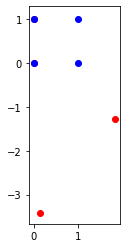

In [90]:
def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y, c='red')
    ax.scatter(X, Y, c='blue')
    ax.set_aspect('equal')
    plt.show()

if __name__ == '__main__':
    main()